In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


in this notebook we will train and save a random forest model then plot and show different metrics for the model

In [4]:
data = pd.read_csv('../data/processed/star_classification.csv')
encoder = LabelEncoder()
data_class = encoder.fit_transform(data['class'])
data_class = pd.DataFrame(data_class, columns=['class'])
#print the number for each class
print(data['class'].value_counts())
print(data_class.value_counts())
#drop the class 3 and class column in data
indice= data_class[data_class['class']==3].index
data = data.drop(indice)
data_class = data_class.drop(indice)
data = data.drop('class', axis=1)
#split the data into train and test with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(data, data_class, test_size=0.2, random_state=42) 


class
GALAXY    59444
STAR      21593
QSO       18961
Name: count, dtype: int64
class
0        59444
2        21593
1        18961
3            1
Name: count, dtype: int64


We do a grid search to find the best parameters for the model

We run this code in google colab and save the data of the grid searh in a csv file

 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1TqehMW7PY5Uu6mqdNrI-QY-2_uj9qFE5?authuser=2#scrollTo=yZtNVPu0hrp-)

In [ ]:
#grid search for random forest
param_grid = {
    'bootstrap': [True],
    'random_state': [0],
    'max_depth': [10,20,30, None],
    'max_features': ["sqrt", "log2",0.5],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,5,10],
    'n_estimators': [100, 200, 300],
    'class_weight': [None,'balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy']
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=4, n_jobs=-1, verbose=3, scoring='f1_macro', pre_dispatch='4*n_jobs')
# Fit the grid search to the data
grid_search.fit(X_train, np.ravel(y_train))
grid_search.best_params_

In [ ]:
#random search for random forest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
param_dist = {
    'bootstrap': [True],
    'random_state': [0],
    'max_depth': sp_randint(10, 100),
    'max_features': sp_randint(1, 8),
    'min_samples_leaf': sp_randint(1, 10),
    'min_samples_split': sp_randint(5, 20),
    'n_estimators': sp_randint(100, 700),
    'class_weight': [None,'balanced', 'balanced_subsample'],
    'criterion': ['gini'],
    'warm_start': [False],
    'ccp_alpha': [0],
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                           cv=4, n_jobs=-1, verbose=3, scoring='f1_macro', pre_dispatch='4*n_jobs')
# Fit the grid search to the data
random_search.fit(X_train, np.ravel(y_train))
result = pd.DataFrame(grid_search.cv_results_)
result.to_csv('/content/drive/MyDrive/Colab Notebooks/result.csv')

load the result from the grid search and plot the results

In [2]:
result = pd.read_csv('../data/external/result_randomforest.csv')
result = result.drop(['Unnamed: 0'], axis=1)
best_result = result[result['rank_test_score'] == 1]
print(best_result["mean_test_score"])
params = pd.DataFrame(best_result["params"])["params"].values[0]
params = eval(params)


1196    0.75046
Name: mean_test_score, dtype: float64


Train the model with the best parameters and save it

In [5]:
from joblib import dump
rf = RandomForestClassifier(**params)
train, test, train_class, test_class = train_test_split(data, data_class, test_size=0.2, random_state=0)
model = rf.fit(train, np.ravel(train_class))

filename = '../models/randomforest_model.joblib'
dump(model, filename)

['../models/randomforest_model.joblib']

Show results of the model, plot the confusion matrix and show the classification report

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     11859
           1       0.70      0.71      0.71      3840
           2       0.71      0.66      0.68      4301

    accuracy                           0.81     20000
   macro avg       0.76      0.75      0.76     20000
weighted avg       0.81      0.81      0.81     20000

auc score for class 0:  0.8981512069109047
auc score for class 1:  0.8884913076268565
auc score for class 2:  0.8749150176820241


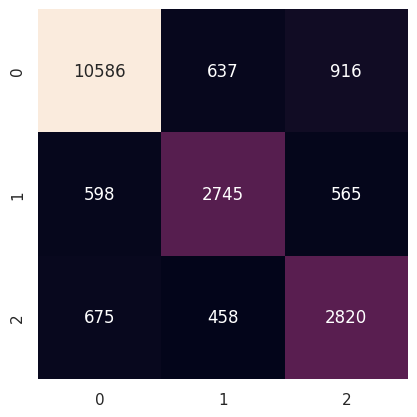

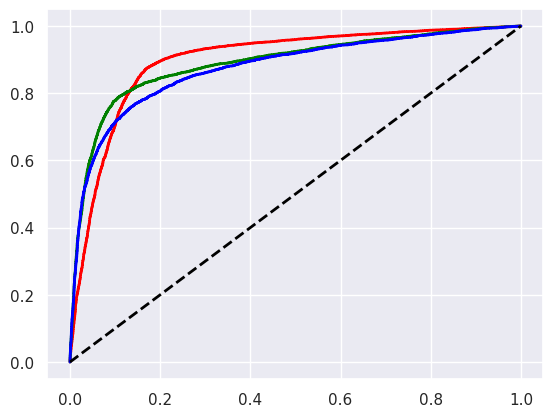

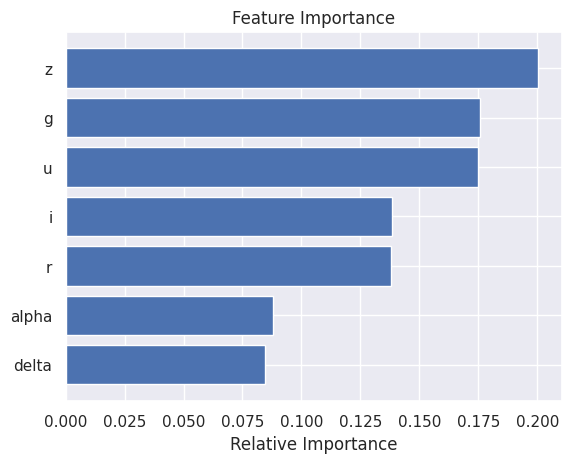

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#classification report
y_pred = model.predict(test)
print(classification_report(test_class, y_pred))
#confusion matrix
sns.set()
mat = confusion_matrix(test_class, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
#roc curve
y_score = model.predict_proba(test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_class, y_score[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
sns.set()
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='Class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green',
            lw=lw, label='Class 1 (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue',
            lw=lw, label='Class 2 (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
# auc score
print("auc score for class 0: ", roc_auc[0])
print("auc score for class 1: ", roc_auc[1])
print("auc score for class 2: ", roc_auc[2])
#feature importance
importance = model.feature_importances_
indices = np.argsort(importance)
plt.figure()
plt.title('Feature Importance')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), data.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

we try to ameliorate by selecting the best tree to use in the forest

/usr/local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does 

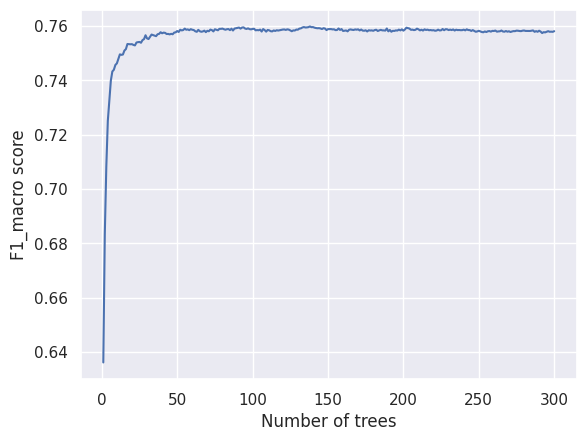

In [13]:
import copy
#calculate the f1_macro score for each tree
f1_macro = []
for estimator in model.estimators_:
    y_pred = estimator.predict(test.values)
    f1_macro.append(sk.metrics.f1_score(test_class, y_pred, average='macro'))   
#estimators and f1_macro score in a dataframe
estimators = pd.DataFrame({'estimators': model.estimators_, 'f1_macro': f1_macro})
#arrange estimators by f1_macro score in descending order
estimators = estimators.sort_values(by=['f1_macro'], ascending=False)
#compute the f1 score for the first, the first two, the first three, ... trees
f1_macro_cumul = []
for i in range(1, len(estimators)+1):
    new_model = copy.deepcopy(model)
    new_model.estimators_ = estimators['estimators'].iloc[:i].tolist()
    y_pred = new_model.predict(test.values)
    f1_macro_cumul.append(sk.metrics.f1_score(test_class, y_pred, average='macro'))
#plot the f1_macro score for each number of trees
plt.figure()
plt.plot(range(1, len(estimators)+1), f1_macro_cumul)
plt.xlabel('Number of trees')
plt.ylabel('F1_macro score')
plt.show()